In [1]:
# Init
import glob
import os
import pickle
import sys

module_path = os.path.abspath(os.path.join("../src/simulicronalpha/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import multiprocessing
import warnings

# Imports
import numpy as np
import pandas as pd

np.set_printoptions(suppress=True)
import random

# Plotting imports
import altair as alt
from numpy import concatenate as c
from numpy import cumsum

alt.data_transformers.disable_max_rows()
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
# Acc. functions
def returnLast(lst):
    return lst[-1]


def returnGen(lst, gen):
    return lst[gen]


def return100(lst):
    return lst[:100]


def colorRanges(i):
    if i == 0:
        return "0"
    elif i > 0 and i <= 50:
        return "1-50"
    elif i > 50 and i <= 100:
        return "50-100"
    elif i > 100 and i <= 200:
        return "100-200"
    elif i > 200 and i <= 300:
        return "200-300"
    elif i > 300:
        return ">300"


def zeroDivision(n, d):
    return n / d if d else maxVal

In [3]:
# Path to results
resultDir = "../etaVsHG/"

# Add them to a list
resultList = []
for filename in glob.glob(os.path.join(resultDir, "*.pickle")):
    with open(filename, "rb") as f:
        resultList.append(pickle.load(f))

# Store results in a dataframe
resultDataframe = pd.DataFrame(resultList)

In [4]:
# Create a copy for inplace handling
resultDataframeC = resultDataframe.copy()

In [5]:
# Perform some data wrangling2000
resultDataframeC[["TranspositionRate_1", "TranspositionRate_2"]] = pd.DataFrame(
    resultDataframeC.TRate.tolist(), index=resultDataframeC.index
)
resultDataframeC[["TE_1_CN", "TE_2_CN"]] = resultDataframeC["TEfamilyCN"].apply(
    pd.Series
)
resultDataframeC[["TE_1_RG", "TE_2_RG"]] = resultDataframeC["TEfamilyRg"].apply(
    pd.Series
)
resultDataframeC[["TE_1_pi", "TE_2_pi"]] = resultDataframeC["TEpi"].apply(pd.Series)

# Add column for the last acn (average copy number) for each transposon family
resultDataframeC["TE_1_ACN"] = resultDataframeC["TE_1_CN"].apply(
    lambda x: returnLast(x)
)
resultDataframeC["TE_2_ACN"] = resultDataframeC["TE_2_CN"].apply(
    lambda x: returnLast(x)
)
# resultDataframeC['TE_1_ACN'] = resultDataframeC['TE_1_CN'].apply(lambda x: returnGen(x))
# resultDataframeC['TE_2_ACN'] = resultDataframeC['TE_2_CN'].apply(lambda x: returnGen(x))

# Add column for the generation number at 100 (list)
resultDataframeC["TE_1_ACN100"] = resultDataframeC["TE_1_CN"].apply(
    lambda x: return100(x)
)
resultDataframeC["TE_2_ACN100"] = resultDataframeC["TE_2_CN"].apply(
    lambda x: return100(x)
)

# Add column for the generation number at 100
resultDataframeC["TE_1_100CN"] = resultDataframeC["TE_1_CN"].apply(
    lambda x: returnGen(x, 1500)
)
resultDataframeC["TE_2_100CN"] = resultDataframeC["TE_2_CN"].apply(
    lambda x: returnGen(x, 1500)
)

# Get ranges for adding colors later
resultDataframeC["TE_1_ACN_R"] = resultDataframeC["TE_1_ACN"].apply(
    lambda x: colorRanges(x)
)
resultDataframeC["TE_2_ACN_R"] = resultDataframeC["TE_2_ACN"].apply(
    lambda x: colorRanges(x)
)

# Add column for copies not present in clusters
resultDataframeC["TE_1_NCN"] = (
    resultDataframeC["TE_1_ACN"] - resultDataframeC["TE_1_pi"]
)
resultDataframeC["TE_2_NCN"] = (
    resultDataframeC["TE_2_ACN"] - resultDataframeC["TE_2_pi"]
)
resultDataframeC["TE_1_NCN_l"] = np.log(
    resultDataframeC["TE_1_ACN"] - resultDataframeC["TE_1_pi"]
)
resultDataframeC["TE_2_NCN_l"] = np.log(
    resultDataframeC["TE_2_ACN"] - resultDataframeC["TE_2_pi"]
)

# Add a ratio column!
# First find the highest value in the whole column
maxVal = resultDataframeC["TE_1_100CN"].max()
resultDataframeC["TE_100R"] = resultDataframeC.apply(
    lambda x: zeroDivision(x["TE_1_100CN"], x["TE_2_100CN"]), axis=1
)
resultDataframeC["TE_R"] = resultDataframeC.apply(
    lambda x: zeroDivision(x["TE_1_ACN"], x["TE_2_ACN"]), axis=1
)

# Some wrangling for plotly go
x = resultDataframeC["ETA"]
y = resultDataframeC["selPen"]
TE1ACN = resultDataframeC["TE_1_ACN"]
TE2ACN = resultDataframeC["TE_2_ACN"]

# Convert count to log scale
resultDataframeC["TE_1_ACN_l"] = np.log(resultDataframeC["TE_1_ACN"])
resultDataframeC["TE_2_ACN_l"] = np.log(resultDataframeC["TE_2_ACN"])

/home/siddharth/mambaforge/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
df0 = resultDataframeC[resultDataframeC["HGTGen"] < 1]
dfn0 = resultDataframeC[resultDataframeC["HGTGen"] > 0]

In [7]:
# Create list of dataframes according to HGTgen
dfList = []
TL = []
ACN_l = []
ETA = []
HGTGen = []
for i in set(sorted(resultDataframeC["HGTGen"].tolist())):
    dfList.append(resultDataframeC[resultDataframeC["HGTGen"] == i])
    currentDF = resultDataframeC[resultDataframeC["HGTGen"] == i]
    TL = TL + (
        ["TE1"] * len(currentDF["TE_1_100CN"]) + ["TE2"] * len(currentDF["TE_2_100CN"])
    )
    ACN_l = ACN_l + (
        currentDF["TE_1_100CN"].tolist() + currentDF["TE_2_100CN"].tolist()
    )
    ETA = ETA + (currentDF["ETA"].tolist() + currentDF["ETA"].tolist())
    HGTGen = HGTGen + (
        [i] * len(currentDF["TE_1_ACN_l"]) + [i] * len(currentDF["TE_2_ACN_l"])
    )
ScatterFrame = pd.DataFrame(
    {"TransposonType": TL, "ACN": ACN_l, "ETA": ETA, "HGTGen": HGTGen}
)
ScatterFrame["HGTGen"] = ScatterFrame["HGTGen"].astype(str)

In [8]:
currentDF = resultDataframeC
dfList = []
TL = []
ACN_l = []
ETA = []
HGTGen = []
TL = TL + (["TE1"] * len(currentDF["TE_1_ACN"]) + ["TE2"] * len(currentDF["TE_2_ACN"]))
ACN_l = ACN_l + (currentDF["TE_1_ACN"].tolist() + currentDF["TE_2_ACN"].tolist())
ETA = ETA + (currentDF["ETA"].tolist() + currentDF["ETA"].tolist())
HGTGen = currentDF["HGTGen"].tolist() + currentDF["HGTGen"].tolist()
ScatterFrameC = pd.DataFrame(
    {"TransposonType": TL, "ACN": np.log(ACN_l), "ETA": ETA, "HGTGen": HGTGen}
)
ScatterFrameC["HGTGen"] = ScatterFrameC["HGTGen"].astype(str)

<ipython-input-8-6bc4a7ecde36>:12: RuntimeWarning: divide by zero encountered in log
  {"TransposonType": TL, "ACN": np.log(ACN_l), "ETA": ETA, "HGTGen": HGTGen}


In [9]:
chart1 = (
    alt.Chart(ScatterFrameC)
    .mark_circle(size=150)
    .encode(
        x="ETA:Q",
        y="HGTGen:Q",
        color=alt.Color("ACN:Q", scale=alt.Scale(scheme="inferno")),
    )
    .properties(
        width=400,
        height=400,
    )
    .facet(column="TransposonType:N")
)

In [10]:
chart1

alt.FacetChart(...)

In [11]:
currentDF = resultDataframeC
TE1_TE2 = []
ETA = []
HGTGen = []
ETA = ETA + (currentDF["ETA"].tolist() + currentDF["ETA"].tolist())
HGTGen = currentDF["HGTGen"].tolist() + currentDF["HGTGen"].tolist()
TE1_TE2 = currentDF["TE_100R"].tolist() + currentDF["TE_100R"].tolist()
ScatterFrameC = pd.DataFrame({"TE1/TE2": TE1_TE2, "ETA": ETA, "HGTGen": HGTGen})
ScatterFrameC["HGTGen"] = ScatterFrameC["HGTGen"].astype(str)
ScatterFrameC["Log TE1/TE2"] = np.log(ScatterFrameC["TE1/TE2"])

In [12]:
chart4 = (
    alt.Chart(ScatterFrameC)
    .mark_circle(size=150)
    .encode(
        x="ETA:Q",
        y="HGTGen:Q",
        color=alt.Color(
            "Log TE1/TE2:Q", scale=alt.Scale(scheme="redyellowgreen", domain=[-6, 6])
        ),
    )
    .properties(
        width=400,
        height=400,
    )
)
chart4

#    color = alt.Color('TE1/TE2:Q',
#        scale=alt.Scale(scheme='inferno')),

alt.Chart(...)

In [ ]:
resultList

In [ ]:
currentDF = df0
dfList = []
TL = []
ACN_l = []
ETA = []
HGTGen = []
TL = TL + (
    ["TE1"] * len(currentDF["TE_1_100CN"]) + ["TE2"] * len(currentDF["TE_2_100CN"])
)
ACN_l = ACN_l + (currentDF["TE_1_100CN"].tolist() + currentDF["TE_2_100CN"].tolist())
ETA = ETA + (currentDF["ETA"].tolist() + currentDF["ETA"].tolist())
HGTGen = currentDF["HGTGen"].tolist() + currentDF["HGTGen"].tolist()
ScatterFrameC = pd.DataFrame(
    {"TransposonType": TL, "ACN": ACN_l, "ETA": ETA, "HGTGen": HGTGen}
)
ScatterFrameC["HGTGen"] = ScatterFrameC["HGTGen"].astype(str)

In [ ]:
chart2 = (
    alt.Chart(ScatterFrameC)
    .mark_circle(size=100, clip=True)
    .encode(
        alt.X("ETA"),
        alt.Y("ACN"),
        color="TransposonType",
    )
    .properties(
        width=400,
        height=400,
    )
)

In [ ]:
chart3 = chart1 | chart2

In [ ]:
chart3.configure_axis(labelFontSize=25, titleFontSize=25).configure_legend(
    gradientLength=300,
    gradientThickness=30,
    labelFontSize=20,
    titleFontSize=20,
).configure_header(titleFontSize=30, labelColorresultDataframeC="red", labelFontSize=25)

In [ ]:
sns.scatterplot(data=ScatterFrameC, x="ETA", y="ACN")

In [ ]:
# Using seaborn
g = sns.FacetGrid(
    ScatterFrame, col="HGTGen", hue="TransposonType", col_wrap=4, height=5
)
g.map(sns.scatterplot, "ACN", "ETA", alpha=0.7)
g.add_legend()

In [ ]:
fig = px.scatter(
    ScatterFrame, x="ACN_log", y="ETA", color="TransposonType", facet_col="HGTGen"
)
fig.show()

In [7]:
# Create a longform dataset for scatter plot and mend it for facetgrid


currentDF = dfList[0]
TL = ["TE1"] * len(currentDF["TE_1_ACN_l"]) + ["TE2"] * len(currentDF["TE_2_ACN_l"])
ACN_l = currentDF["TE_1_ACN_l"].tolist() + currentDF["TE_2_ACN_l"].tolist()
ETA = currentDF["ETA"].tolist() + currentDF["ETA"].tolist()
markerSym = ["circle"] * len(currentDF["TE_1_ACN_l"]) + ["cross"] * len(
    currentDF["TE_2_ACN_l"]
)
HGTGen = currentDF["HGTGen"].tolist() + currentDF["HGTGen"].tolist()
# Creating the dataframe
ScatterFrame = pd.DataFrame(
    {
        "TransposonType": TL,
        "ACN_log": ACN_l,
        "ETA": ETA,
        "HGTGen": HGTGen,
        "markerSym": markerSym,
    }
)

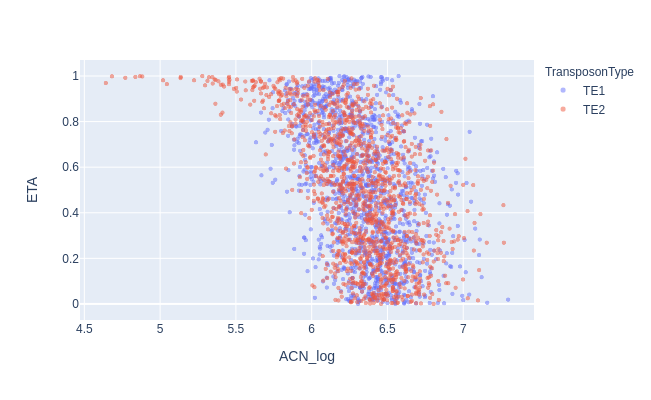

In [10]:
# Creating scatter plots
fig = px.scatter(
    ScatterFrame,
    x="ACN_log",
    y="ETA",
    color="TransposonType",
    width=400,
    height=400,
    opacity=0.5,
)
fig.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top",
        y=1,
        x=-0.2,
        ticks="inside",
    )
)
fig.update_traces(
    marker=dict(size=5, line=dict(width=0, color="white")),
    selector=dict(mode="markers"),
)

In [ ]:
# Create a scatter plot - first create a longform dataset
TL = ["TE1"] * len(resultDataframeC["TE_1_ACN_l"]) + ["TE2"] * len(
    resultDataframeC["TE_2_ACN_l"]
)
ACN_l = (
    resultDataframeC["TE_1_ACN_l"].tolist() + resultDataframeC["TE_2_ACN_l"].tolist()
)
ETA = resultDataframeC["ETA"].tolist() + resultDataframeC["ETA"].tolist()
markerSym = ["circle"] * len(resultDataframeC["TE_1_ACN_l"]) + ["cross"] * len(
    resultDataframeC["TE_2_ACN_l"]
)
HGTGen = resultDataframeC["HGTGen"].tolist() + resultDataframeC["HGTGen"].tolist()
# Creating the dataframe
ScatterFrame = pd.DataFrame(
    {
        "TransposonType": TL,
        "ACN_log": ACN_l,
        "ETA": ETA,
        "HGTGen": HGTGen,
        "markerSym": markerSym,
    }
)
# Creating scatter plots
fig = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="ACN_log",
    symbol="markerSym",
    width=800,
    height=800,
    opacity=0.5,
)
fig.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top",
        y=1,
        x=-0.2,
        ticks="inside",
    )
)

# For each subtype
fig1 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="TE_1_ACN",
    color="ETA",
    width=800,
    height=800,
)
fig2 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="TE_2_ACN",
    color="ETA",
    width=800,
    height=800,
)
# fig1.update_layout(xaxis_type="log")
# fig2.update_layout(xaxis_type="log")
# Facet
fig3 = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="ACN_log",
    facet_col="TransposonType",
    width=800,
    height=800,
)

In [ ]:
fig

In [ ]:
fig1
fig1.update_traces(
    marker=dict(size=12, line=dict(width=0, color="white")),
    selector=dict(mode="markers"),
)

In [ ]:
fig2
fig2.update_traces(
    marker=dict(size=12, line=dict(width=0, color="white")),
    selector=dict(mode="markers"),
)

In [ ]:
fig3
fig3.update_traces(
    marker=dict(size=12, line=dict(width=0, color="white")),
    selector=dict(mode="markers"),
)

In [ ]:
# Plot the histogram
# Some dummy arrays and dataframe
TL = ["TE1"] * len(TE1ACN) + ["TE2"] * len(TE2ACN)
ACN = TE1ACN.tolist() + TE2ACN.tolist()
histoFrame = pd.DataFrame({"TransposonType": TL, "AverageCopyNumber": ACN})
fig3 = px.histogram(
    histoFrame,
    x="AverageCopyNumber",
    color="TransposonType",
    width=800,
    height=800,
    marginal="box",
    barmode="overlay",
)
fig3

In [ ]:
# Create a scatter plot - first create a longform dataset
TL = ["TE1"] * len(resultDataframeC["TE_1_NCN_l"]) + ["TE2"] * len(
    resultDataframeC["TE_2_NCN_l"]
)
ACN_l = resultDataframeC["TE_1_NCN"].tolist() + resultDataframeC["TE_2_NCN"].tolist()
ETA = resultDataframeC["ETA"].tolist() + resultDataframeC["ETA"].tolist()
markerSym = ["circle"] * len(resultDataframeC["TE_1_NCN_l"]) + ["cross"] * len(
    resultDataframeC["TE_2_NCN_l"]
)
HGTGen = resultDataframeC["HGTGen"].tolist() + resultDataframeC["HGTGen"].tolist()
# Creating the dataframe
ScatterFrame = pd.DataFrame(
    {
        "TransposonType": TL,
        "ACN": ACN_l,
        "ETA": ETA,
        "HGTGen": HGTGen,
        "markerSym": markerSym,
    }
)
# Creating scatter plots
fig4 = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="ACN",
    symbol="markerSym",
    width=800,
    height=800,
    opacity=0.5,
)
fig4.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top",
        y=1,
        x=-0.2,
        ticks="inside",
    )
)

# For each subtype
fig5 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="ETA",
    color="TE_1_NCN",
    width=800,
    height=800,
)
fig6 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="ETA",
    color="TE_2_NCN",
    width=800,
    height=800,
)
# fig1.update_layout(xaxis_type="log")
# fig2.update_layout(xaxis_type="log")
# Facet
fig7 = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="ACN",
    facet_col="TransposonType",
    width=800,
    height=800,
)

In [ ]:
fig5

In [ ]:
fig6

In [ ]:
fig7

In [ ]:
# Create a scatter plot - first create a longform dataset
TL = ["TE1"] * len(resultDataframeC["TE_1_NCN"]) + ["TE2"] * len(
    resultDataframeC["TE_2_NCN"]
)
ACN_l = resultDataframeC["TE_1_NCN"].tolist() + resultDataframeC["TE_2_NCN"].tolist()
ETA = resultDataframeC["ETA"].tolist() + resultDataframeC["ETA"].tolist()
markerSym = ["circle"] * len(resultDataframeC["TE_1_NCN"]) + ["cross"] * len(
    resultDataframeC["TE_2_NCN"]
)
HGTGen = resultDataframeC["HGTGen"].tolist() + resultDataframeC["HGTGen"].tolist()
# Creating the dataframe
ScatterFrame = pd.DataFrame(
    {
        "TransposonType": TL,
        "ACN": ACN_l,
        "ETA": ETA,
        "HGTGen": HGTGen,
        "markerSym": markerSym,
    }
)
# Add a column for colorscale
ScatterFrame["Transposon Copy Number"] = ScatterFrame["ACN"].apply(
    lambda x: colorRanges(x)
)
# Creating scatter plots
fig8 = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="ACN",
    symbol="markerSym",
    width=800,
    height=800,
    opacity=0.5,
)
fig8.update_layout(
    coloraxis_colorbar=dict(
        yanchor="top",
        y=1,
        x=-0.2,
        ticks="inside",
    )
)

# For each subtype
fig9 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="ETA",
    color="TE_1_NCN",
    width=800,
    height=800,
    color_discrete_sequence=px.colors.sequential.Plasma_r,
)
fig10 = px.scatter(
    resultDataframeC,
    x="HGTGen",
    y="ETA",
    color="TE_2_NCN",
    width=800,
    height=800,
    color_discrete_sequence=px.colors.sequential.Plasma_r,
)
# fig1.update_layout(xaxis_type="log")
# fig2.update_layout(xaxis_type="log")
# Facet
fig11 = px.scatter(
    ScatterFrame,
    x="HGTGen",
    y="ETA",
    color="Transposon Copy Number",
    facet_col="TransposonType",
    width=800,
    height=800,
    template="ggplot2",
)

In [ ]:
fig11
fig11.update_traces(
    marker=dict(size=12, line=dict(width=0, color="white")),
    selector=dict(mode="markers"),
)

In [ ]:
import pandas as pd
import plotly.graph_objs as go
from plotly import tools

trace1 = dict(
    type="scatter3d",
    scene="scene1",
    x=x,
    y=y,
    z=z,
    mode="markers",
    marker=dict(size=5, color=TE1ACN, colorscale="Viridis", opacity=0.8),
)

trace2 = dict(
    type="scatter3d",
    scene="scene2",
    x=x,
    y=y,
    z=z,
    mode="markers",
    marker=dict(size=5, color=TE2ACN, colorscale="Viridis", opacity=0.8),
)

f = tools.make_subplots(rows=1, cols=2, specs=[[{"is_3d": True}, {"is_3d": True}]])

f.append_trace(trace1, 1, 1)
f.append_trace(trace2, 1, 2)

fig = go.FigureWidget(f)


def cam_change(layout, camera):
    fig.layout.scene2.camera = camera


fig.layout.scene1.on_change(cam_change, "camera")
fig.layout.margin.b = 0
fig.layout.margin.l = 0
fig.layout.margin.r = 0
fig.layout.margin.t = 0
fig.layout.margin.pad = 0
fig.update_layout(
    height=500,
    width=500,
    showlegend=False,
)
fig

In [ ]:
# Trying to plot the effective regulation at each generation for each transposon
# Creating a long form dataframe
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(25, 10),)
for index, row in resultDataframeC.iterrows():
    TE1regulation = row['TE_1_RG']
    TE2regulation = row['TE_2_RG']
    # Calculate theoritical regulation
    TE2regulationTheoritical = [i * row['ETA'] for i in TE1regulation]df
    generation = list(range(len(TE1regulation)))
    sns.lineplot(
        x=generation,
        y=TE1regulation,
        color="red",
        ax=ax1,
    ).set_title("TE 1 average regulation")
    sns.lineplot(
        x=generation,
        y=TE2regulationTheoritical,
        color="red",
        ax=ax2,
    ).set_title("TE 2 coregulation regulation")
    sns.lineplot(
        x=generation,
        y=TE2regulation,
        color="red",
        ax=ax3,
    ).set_title("TE 2 average regulation")

In [ ]:
resultDataframeC